# Real-world example - Analysis of scDVP liver zonation dataset 

In this example we showcase how spatialdata can be leveraged in the analysis of real-world DVP data. For this purpose we utilize a small subset of the previously published dataset by {cite:p}`Rosenberger2023` [(Rosenberger et al, 2023)](https://doi.org/10.1038/s41592-023-02007-6), specifically the sample `m1a`. This datasets originally includes 

- IF images (as `.tiff`) of the mouse liver, including the markers Glutamine Synthethase, E-Cadherin, cell membrane marker (WGA), and phalloidin (cytoskeleton)

- Cell segmentation shapes of the profiled cells as LMD-compatible `.xml` file

- Proteomics measurements of 77 single shapes as DIANN protein groups report (`.tsv`)


We generated a single data container of this data in this [tutorial](https://dvp-io.readthedocs.io/en/latest/tutorials/004_scdvp.html). We will now check out how we can use `spatialdata` to jointly store and visualize these different modalities. 

## Packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spatialdata as sd
import spatialdata_plot  # noqa
from napari_spatialdata import Interactive

/Users/lucas-diedrich/mamba/envs/spatialdata/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## Get data

In [2]:
# %%bash
# downloadpath="./scdvp"
# mkdir -p $downloadpath
# wget -O $downloadpath/scdvp.rosenberger2023.gz.tar  "..."
# tar -xvf -d $downloadpath $downloadpath/scdvp-rosenberger2023.gz.tar
# rm $downloadpath/scdvp-rosenberger2023.gz.tar

## Create spatialdata object

We will successively add attributes to our spatialdata object. Let's initialize an empty object:

In [3]:
# Initialize an empty spatialdata object
sdata = sd.read_zarr("./scdvp/rosenberger2023.m1a.sdata.zarr")
sdata

/Users/lucas-diedrich/mamba/envs/spatialdata/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: /Users/lucas-diedrich/Documents/Lab/teaching/Workshops/Group Retreat 2025 - Learn Session - Spatialdata/notebooks/scdvp/rosenberger2023.m1a.sdata.zarr
├── Images
│     └── 'm1a_image': DataArray[cyx] (4, 28486, 19702)
├── Points
│     └── 'calibration_points_image': DataFrame with shape: (<Delayed>, 2) (2D points)
├── Shapes
│     └── 'cell_segmentation': GeoDataFrame shape: (300, 3) (2D shapes)
└── Tables
      └── 'm1a_table': AnnData (77, 3738)
with coordinate systems:
    ▸ 'global', with elements:
        m1a_image (Images), calibration_points_image (Points), cell_segmentation (Shapes)
    ▸ 'to_lmd', with elements:
        cell_segmentation (Shapes)

## Interact with spatialdata

Let's access the raw image. This works similarly to a dictionary lookup. We see that it is an `xarray.DataArray` under the hood. `xarray` nicely visualizes the overall shape of the image. 

In [4]:
sdata.images["m1a_image"]

<xarray.DataArray 'image' (c: 4, y: 28486, x: 19702)> Size: 4GB
dask.array<from-zarr, shape=(4, 28486, 19702), dtype=uint16, chunksize=(1, 28486, 19702), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U10 160B 'GS' 'ECadherin' 'WGA' 'Phalloidin'
  * y        (y) float64 228kB 0.5 1.5 2.5 3.5 ... 2.848e+04 2.848e+04 2.849e+04
  * x        (x) float64 158kB 0.5 1.5 2.5 3.5 ... 1.97e+04 1.97e+04 1.97e+04
Attributes:
    transform:  {'global': Identity }

Let's also take a look at the single-cell segmentation masks, the shapes. They are stored in a `geopandas.GeoDataFrame`

In [10]:
sdata.shapes["cell_segmentation"]

,name,well,geometry
Shape_1,Shape_1,A1,"POLYGON ((1821.81 9911.04, 1820.777 9913.032, ..."
Shape_2,Shape_2,A2,"POLYGON ((17064.669 13664.247, 17058.619 13667..."
Shape_3,Shape_3,A3,"POLYGON ((17047.627 14307.205, 17046.668 14309..."
Shape_4,Shape_4,A4,"POLYGON ((12309.658 18603.255, 12307.666 18606..."
Shape_5,Shape_5,A5,"POLYGON ((7322.622 23598.259, 7321.589 23600.2..."
...,...,...,...
Shape_296,Shape_296,N10,"POLYGON ((5319.013 19246.213, 5317.98 19248.20..."
Shape_297,Shape_297,N11,"POLYGON ((9031.2 4996.009, 9029.208 4999.034, ..."
Shape_298,Shape_298,N12,"POLYGON ((9390.194 5174.031, 9389.235 5176.023..."
Shape_299,Shape_299,N13,"POLYGON ((9129.249 5355.003, 9128.216 5356.995..."


Access a single shape, which are stored as `shapely.Polygon`s

In [12]:
type(sdata.shapes["cell_segmentation"].loc["Shape_1", "geometry"])

shapely.geometry.polygon.Polygon

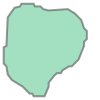

In [11]:
sdata.shapes["cell_segmentation"].loc["Shape_1", "geometry"]

## Images

First, we will plot the image statically with `spatialdata-plot`

### Plotting with spatialdata plot

Check out the [documentation](https://spatialdata.scverse.org/projects/plot/en/stable/plotting.html)

Spatialdata plot directly hooks into spatialdata. You can interact with it by adding the `.pl` accessor to a spatialdata object. Depending on the modality, you would like to plot, you need to add `.pl.render_<xxx>`

You can chain an arbitrary number of `render` functions to the object. E.g. you can add shapes/labels if you have image segmentations or shapes available, you can also add them. 

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3178316032295272].


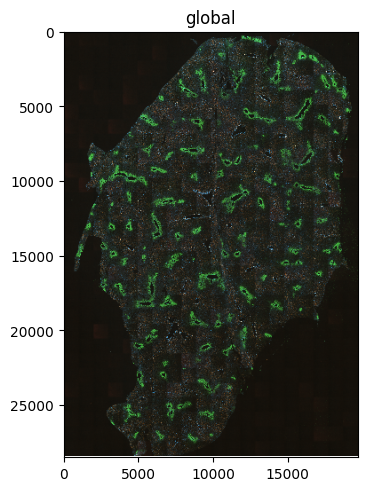

In [5]:
norm = mpl.colors.Normalize(vmin=0, vmax=4000)
(
    sdata
    # Normalize all thress channesl to 0-4000
    .pl.render_images("m1a_image", norm=norm)
    # Specify the coordinate system to show only one
    .pl.show(coordinate_systems="global")
)

## Load shapes

Next, we inspect the shapes.

### Plotting - Overlay of shapes + image
**You should always check/validate whether cell segmentation and image are correctly overlaid.** To do so, we select a small subset of the image and take a look at both cell membrane staining (channel 1) and cell segmentation

/Users/lucas-diedrich/mamba/envs/spatialdata/lib/python3.12/functools.py:912: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)


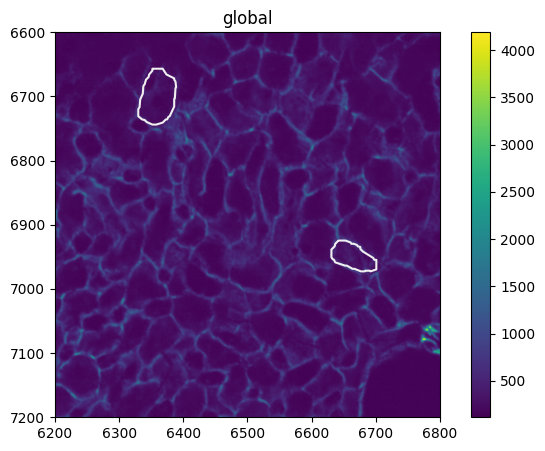

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

min_coordinate = np.array([6200, 6600])
size = 600
(
    sdata.query.bounding_box(
        axes=("x", "y"),
        min_coordinate=min_coordinate,
        max_coordinate=min_coordinate + size,
        target_coordinate_system="global",
    )
    .pl.render_images("m1a_image", channel=1)
    .pl.render_shapes(fill_alpha=0.0, outline_alpha=1, outline_color="#efefef")
    .pl.show(coordinate_systems="global", ax=ax)
)

The overlay between shapes and cell membrane stain looks reasonable. 

### Check out transformation

As we can see, the transformation is stored as a matrix

In [7]:
transformation_shapes = sd.transformations.get_transformation(sdata["cell_segmentation"])
transformation_shapes, transformation_shapes.to_affine(input_axes=("x", "y"), output_axes=("x", "y"))

(Identity ,
 Affine (x, y -> x, y)
     [1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.])

## Omics data

Now we take a look at the omics data. 

### Visualize results
After having added the omics layer to the spatialdata object, **we can overlay the proteomics measurement with the imaging**. In this example, we will focus on E-Cadherin ([P09803](https://www.uniprot.org/uniprotkb/P09803/entry)) for which the original authors also developed an antibody-based staining.

/Users/lucas-diedrich/mamba/envs/spatialdata/lib/python3.12/functools.py:912: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/lucas-diedrich/mamba/envs/spatialdata/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_segmentation` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/lucas-diedrich/mamba/envs/spatialdata/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `m1a_table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/lucas-diedrich/mamba/envs/spatialdata/lib/python3.12/functools.py:912: UserWarning: The object has `points` element. Depending on the number o

Text(0.5, 1.0, 'Cell segmentation + $\\alpha$-E-Cadherin')

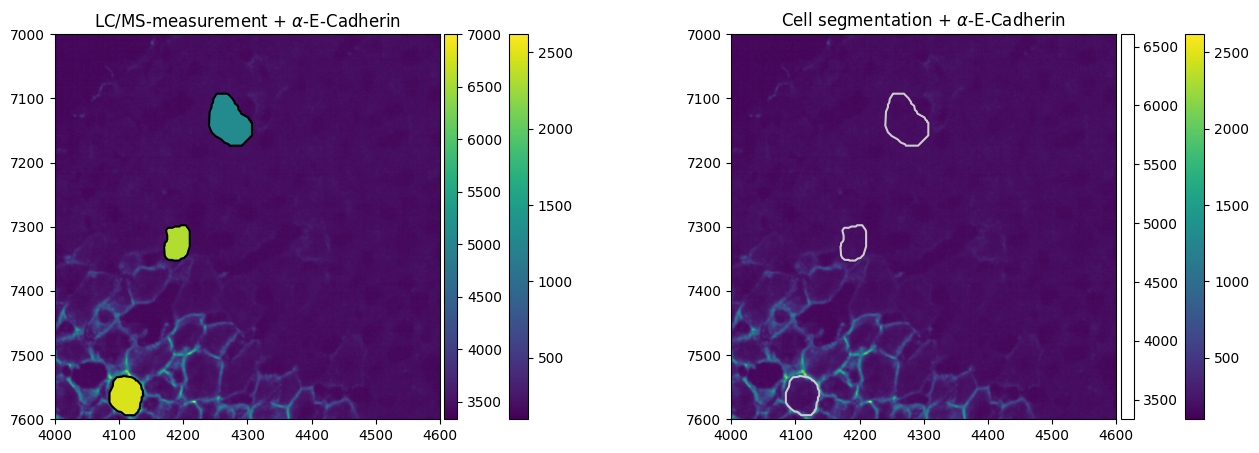

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

min_coordinate = np.array([4000, 7000])
size = 600
(
    sdata
    # Subset to relevant area
    .query.bounding_box(
        axes=("x", "y"),
        min_coordinate=min_coordinate,
        max_coordinate=min_coordinate + size,
        target_coordinate_system="global",
    )
    .pl.render_images("m1a_image", channel=1)
    .pl.render_shapes(
        element="cell_segmentation", color="P09803", norm=mpl.colors.Normalize(0, 7000), outline_alpha=1, fill_alpha=1
    )
    .pl.show(coordinate_systems="global", ax=axs[0])
)

axs[0].set_title("LC/MS-measurement + $\\alpha$-E-Cadherin")

(
    sdata
    # Subset to relevant area
    .query.bounding_box(
        axes=("x", "y"),
        min_coordinate=min_coordinate,
        max_coordinate=min_coordinate + size,
        target_coordinate_system="global",
    )
    .pl.render_images("m1a_image", channel=1)
    .pl.render_shapes(
        element="cell_segmentation", color="P09803", outline_alpha=1, outline_color="#cccccc", fill_alpha=0
    )
    .pl.show(coordinate_systems="global", ax=axs[1])
)

axs[1].set_title("Cell segmentation + $\\alpha$-E-Cadherin")

We note that the staining intensity correlates with the measured abundance of E-Cadherin in the cells. 

## Interactive visualization

Lastly, let's visualize and annotate a tissue structure in the spatialdata object with napari

In [9]:
# Pass spatialdata object to napari
interactive_session = Interactive(sdata)

![](./img/napari-annotation-scdvp.gif)